## Breast Cancer Detection
This notebook will walkthrough my solution to building a model that detects whether a biopsied cell is benign or malignant.

In [211]:
#General Libraries
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

#ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

In [2]:
#Look at the data
!head -n 3 ../breast-cancer-wisconsin.csv

In [15]:
data = pd.read_csv('../breast-cancer-wisconsin.csv')
data.columns= ['sample_id', 'clump_thick', 'uniform_size','uniform_shape',
              'marginal_adhe', 'epithelial_size', 'bare_nuclei','bland_chromatin',
              'normal_nucleoli','mitoses','class']
data.head(n=20)

,sample_id,clump_thick,uniform_size,uniform_shape,marginal_adhe,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1002945,5,4.0,4.0,5.0,large,10,3.0,2.0,1.0,2
1,1015425,?,1.0,1.0,1.0,small,2,3.0,1.0,1.0,2
2,1016277,6,8.0,8.0,1.0,small,4,3.0,7.0,1.0,2
3,1017023,4,1.0,1.0,3.0,small,1,3.0,1.0,1.0,2
4,1017122,8,10.0,10.0,8.0,large,10,NaN,7.0,1.0,4
5,1018099,1,1.0,1.0,1.0,small,10,3.0,1.0,1.0,2
6,1018561,2,1.0,2.0,1.0,small,1,3.0,1.0,1.0,2
7,1033078,2,1.0,1.0,1.0,small,1,1.0,1.0,5.0,2
8,1033078,4,2.0,1.0,1.0,small,1,2.0,1.0,1.0,2
9,1035283,1,1.0,1.0,1.0,?,1,3.0,1.0,1.0,2


# Part 1: Data Cleaning & formatting
The data appear to have both NaN and "?" as inputs. Moreover, the describe function tells us that variables like clump_thick and bare_nuclei should be a numeric value, yet it does not have any mean/std suggesting that data types need to be fixed.

In [17]:
data.describe(include= 'all')

,sample_id,clump_thick,uniform_size,uniform_shape,marginal_adhe,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.980000e+02,698,687.000000,663.000000,677.000000,698,690,685.000000,680.000000,675.000000,698.000000
unique,NaN,10,NaN,NaN,NaN,4,11,NaN,NaN,NaN,NaN
top,NaN,1,NaN,NaN,NaN,small,1,NaN,NaN,NaN,NaN
freq,NaN,145,NaN,NaN,NaN,499,397,NaN,NaN,NaN,NaN
mean,1.071807e+06,NaN,3.097525,3.143288,2.809453,NaN,NaN,3.398540,2.857353,1.576296,2.690544
std,6.175323e+05,NaN,3.031051,2.912466,2.848860,NaN,NaN,2.408622,3.052116,1.706516,0.951596
min,6.163400e+04,NaN,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000,1.000000,2.000000
25%,8.702582e+05,NaN,1.000000,1.000000,1.000000,NaN,NaN,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,NaN,1.000000,1.000000,1.000000,NaN,NaN,3.000000,1.000000,1.000000,2.000000
75%,1.238354e+06,NaN,5.000000,5.000000,4.000000,NaN,NaN,4.000000,3.250000,1.000000,4.000000


In [42]:
for i in list(data.columns):
    print ("The data in column '{0}' are of type {1}".format(i, type(data[i][0])))

The data in column 'sample_id' are of type <class 'numpy.int64'>
The data in column 'clump_thick' are of type <class 'str'>
The data in column 'uniform_size' are of type <class 'numpy.float64'>
The data in column 'uniform_shape' are of type <class 'numpy.float64'>
The data in column 'marginal_adhe' are of type <class 'numpy.float64'>
The data in column 'epithelial_size' are of type <class 'str'>
The data in column 'bare_nuclei' are of type <class 'str'>
The data in column 'bland_chromatin' are of type <class 'numpy.float64'>
The data in column 'normal_nucleoli' are of type <class 'numpy.float64'>
The data in column 'mitoses' are of type <class 'numpy.float64'>
The data in column 'class' are of type <class 'numpy.int64'>


In [60]:
for i in list(data):
    print("The unique values of this variable {0} are \n{1}".format(i, set(data[i])))

The unique values of this variable sample_id are 
{1173509, 1212422, 1079304, 1173514, 1056784, 1126417, 1204242, 770066, 1304595, 866325, 677910, 534555, 1116192, 1058849, 145447, 841769, 1206314, 1050670, 1198128, 1298484, 1345593, 1026122, 1202253, 1294413, 1167439, 385103, 749653, 1110102, 1044572, 1214556, 1050718, 1048672, 1325159, 303213, 1167471, 1243256, 1171578, 1253505, 536708, 1257608, 1241232, 1112209, 1230994, 897172, 1147044, 1347749, 1183911, 792744, 1179818, 1106095, 1257648, 1173681, 352431, 1218741, 1216694, 1261751, 659642, 1276091, 1267898, 1296572, 1239232, 760001, 61634, 1368267, 1331405, 1296593, 1368273, 1331412, 1294562, 342245, 1196263, 1272039, 827627, 1265899, 1183983, 1018099, 1057013, 1333495, 1325309, 1171710, 1280258, 1196295, 780555, 1222936, 1124651, 1218860, 1057067, 1120559, 1321264, 1022257, 1239347, 1311033, 561477, 1227081, 508234, 1204558, 1171795, 434518, 1257815, 657753, 1223003, 1272166, 1347943, 1321321, 672113, 1239420, 690557, 1175937, 132

The dataset has a number of nan and ? as missing data. The next step is to clean this.

In [73]:
new_data = data.replace(['?','1','2','3','4','5','6','7','8','9','10'], [np.nan, 1,2,3,4,5,6,7,8,9,10])
new_data['class'] = new_data['class'].replace([2,4],[0,1])

## How much missing data is there in each column?
Now that we know what type of missing data there are, I now want to ascertain how much data is missing. This will influence the algorithm used in the final model and also affect the imputation methods.

In [78]:
for c in list(new_data):
    print (c)

sample_id
clump_thick
uniform_size
uniform_shape
marginal_adhe
epithelial_size
bare_nuclei
bland_chromatin
normal_nucleoli
mitoses
class


In [108]:
cumulative = 0

for c in list(new_data):

    num_nans= sum(pd.isna(new_data[c]))
    frac_nans= np.round((len(new_data) - num_nans)/len(new_data) * 100,2)
    cumulative += frac_nans
    print("The variable {0}, is {1}% complete".format(c,frac_nans))


average = np.round(cumulative/len(new_data.columns), 2)
print("The average completeness of this dataset is {0}%".format(average))

The variable sample_id, is 100.0% complete
The variable clump_thick, is 84.53% complete
The variable uniform_size, is 98.42% complete
The variable uniform_shape, is 94.99% complete
The variable marginal_adhe, is 96.99% complete
The variable epithelial_size, is 98.71% complete
The variable bare_nuclei, is 96.56% complete
The variable bland_chromatin, is 98.14% complete
The variable normal_nucleoli, is 97.42% complete
The variable mitoses, is 96.7% complete
The variable class, is 100.0% complete
The average completeness of this dataset is 96.59%


In [87]:
len(new_data)

698

In [93]:
list(new_data.columns)

['sample_id',
 'clump_thick',
 'uniform_size',
 'uniform_shape',
 'marginal_adhe',
 'epithelial_size',
 'bare_nuclei',
 'bland_chromatin',
 'normal_nucleoli',
 'mitoses',
 'class']

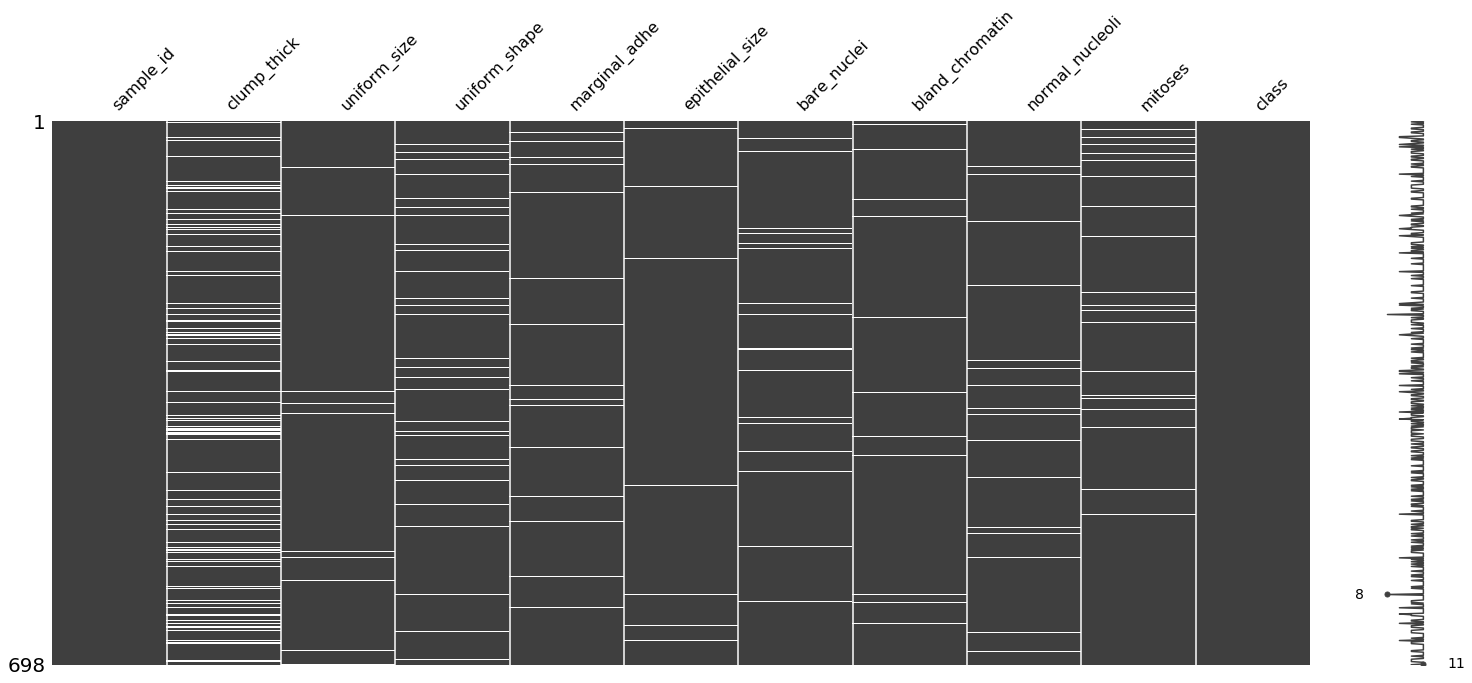

In [111]:
msno.matrix(new_data)

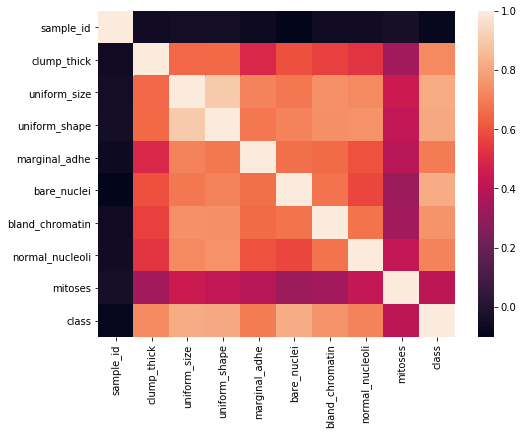

In [116]:
plt.figure(figsize=(8,6))
corr = new_data.corr()
sns.heatmap(corr,
           xticklabels= corr.columns.values,
           yticklabels=corr.columns.values)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a28bfac18>,
      dtype=object)

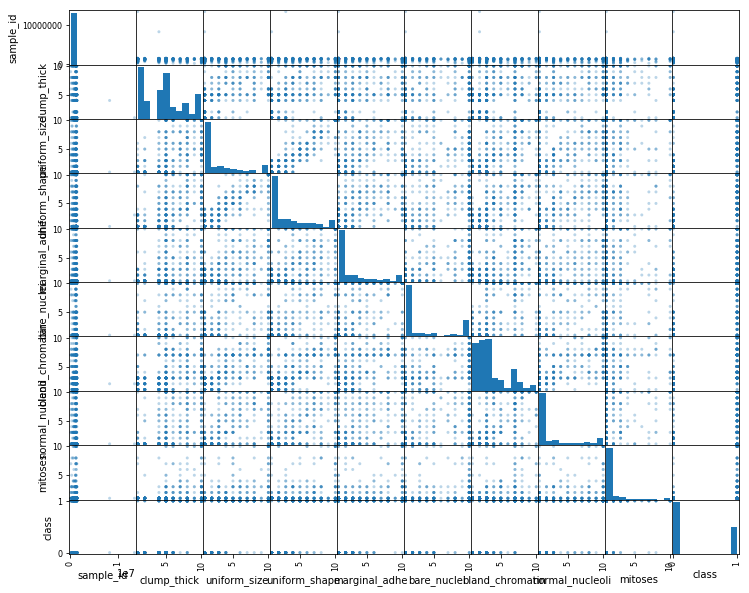

In [118]:
from pandas.plotting import scatter_matrix
scatter_matrix(new_data, figsize=(12,10), alpha = 0.3)

## Data Modelling and evaluation
Now that we know the type of missing data, how much missing data there is, we now move onto repairing the dataset and modelling.

In [124]:
new_data['epithelial_size']= new_data['epithelial_size'].replace(['small','medium','large'], [1,2,3])

In [204]:
x_columns= ['clump_thick',
 'uniform_size',
 'uniform_shape',
 'marginal_adhe',
 'epithelial_size',
 'bare_nuclei',
 'bland_chromatin',
 'normal_nucleoli',
 'mitoses',]

y_columns= 'class'

X = new_data[x_columns].copy()
Y = new_data[y_columns].copy()

## Dealing with missing values

In [205]:
X.fillna(X.mean(), inplace= True)

## Machine Learning
Training before model building

In [206]:
x_train, x_test, y_train, y_test = train_test_split(X.values,Y.values,test_size= 0.4,random_state=0)

## Model 1: Logistic Regression
Bootstrap sample then run Logistic regression

In [207]:
def CreateBootstrapSample(frac=0.8):
    cancer_indices = np.array([i for i in range(len(y_train)) if y_train[i]==1])
    not_cancer_indices = np.array([i for i in range(len(y_train)) if y_train[i]==0])
    sample_size = int(np.round( len(cancer_indices) * frac ))
    cancer_sample = np.random.randint(0,len(cancer_indices),sample_size) 
    not_cancer_sample = np.random.randint(0,len(not_cancer_indices),sample_size)
    y_sample = np.concatenate([y_train[cancer_indices][cancer_sample],y_train[not_cancer_indices[not_cancer_sample]]])
    x_sample = np.concatenate([x_train[cancer_indices][cancer_sample],x_train[not_cancer_indices[not_cancer_sample]]])
    return x_sample,y_sample

In [208]:
M1 = LogisticRegression()

# Run Bootstrapping for 3 cycles to train Model
for i in range(3):
    sample_x,sample_y = CreateBootstrapSample()
    M1.fit(sample_x, sample_y)

y_pred = M1.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}\n\n'.format(M1.score(x_test, y_test)))

confusion_matrix = cm(y_test, y_pred)

target_names = ['Benign','Cancer']
print('CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred, target_names=target_names))

Accuracy of logistic regression classifier on test set: 0.95


CLASSIFICATION REPORT
             precision    recall  f1-score   support

     Benign       0.97      0.96      0.96       179
     Cancer       0.92      0.95      0.94       101

avg / total       0.95      0.95      0.95       280



In [212]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.95530726 0.04469274]
 [0.04950495 0.95049505]]


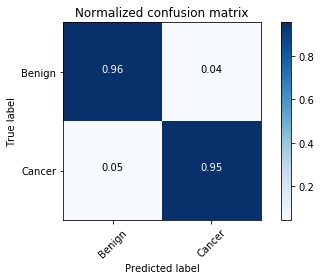

In [213]:
plt.figure()
plot_confusion_matrix(confusion_matrix, classes= target_names, normalize= True,
                     title='Normalized confusion matrix')

Confusion matrix, without normalization
[[171   8]
 [  5  96]]


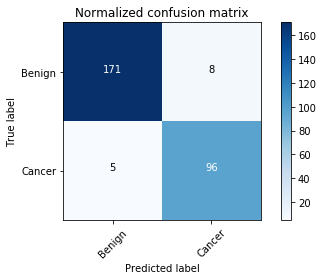

In [214]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=False,
                      title='Normalized confusion matrix')

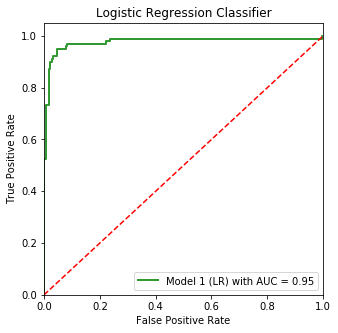

In [215]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure(figsize=(5,5))

logit_roc_auc = roc_auc_score(y_test, M1.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, M1.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, 'g', alpha=0.8, linewidth=2.0,label='Model 1 (LR) with AUC = %0.2f' % (logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier')
plt.legend(loc="lower right")

# # Conclusion
A logistic regression is able to predict whether a tumor is benign or malignant with an accuracy of 95%. Other models could be employed such as a Random Forest model or, possibly, a neural network classifier. However, given that we can predict much of the variance, 